# Coronavirus Daily Cases Forecasting with LSTMs using PyTorch in Python 

Based Venelin [Valkov's tutorial](https://www.youtube.com/watch?v=8A6TEjG2DNw)

Time series data captures a series of data points captured at (usually) regular intervals. Some common examples include daily weather temperature, stock prices, and the number of Coronavirus cases.

Many classical methods (e.g. ARIMA) try to deal with Time Series data with varying success (not to say they are bad at it). In the last couple of years, [Long Short Term Memory Networks (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) models have become a very useful method when dealing with those types of data.

Those types of networks are very good at processing sequences of data. They can "recall" patterns in the data that are very far into the past (or future). In this tutorial, you're going to learn how to use LSTMs to predict future Coronavirus cases based on real-world data.

## Novel Coronavirus (COVID-19)

Many cases are currently not reported due to:

- A person can get infected without even knowing (asymptomatic)
- Incorrect data reporting
- Not enough test kits
- The symptoms look a lot like the common flu

In [1]:
!pip install seaborn

In [2]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Daily Cases Dataset

The data is provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) and contains the number of reported daily cases by country. [The dataset is available on GitHub](https://github.com/CSSEGISandData/COVID-19) and is updated regularly.

We're going to take the Time Series data only for confirmed cases (number of deaths and recovered cases are also available):

In [0]:
# !wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
!mv time_series_19-covid-Confirmed.csv time_series_19-covid-Confirmed_march22.csv

In [3]:
!ls 

time_series_19-covid-Confirmed_march22.csv  time_series_covid_19_march22.ipynb
time_series_covid_19.ipynb


## Data exploration

Let's load the data and have a peek:

In [4]:
df = pd.read_csv('time_series_19-covid-Confirmed_march22.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,75,82,114,147,177,212,272,322,411,599
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,701,773,839,825,878,889,924,963,1007,1086
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,200,212,226,243,266,313,345,385,432,455
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,2
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,197,238,428,566,673,790,900,1030,1183,1306


In [5]:
df.shape

(487, 65)

Two things to note here:

- The data contains a province, country, latitude, and longitude. We won't be needing those.
- The number of cases is cumulative. We'll undo the accumulation.

Let's start by getting rid of the first four columns:

In [6]:
df = df.iloc[:, 4:]

In [7]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,2,3,5,7,8,8,14,14,14,19,...,75,82,114,147,177,212,272,322,411,599
1,2,1,2,2,4,4,7,7,11,15,...,701,773,839,825,878,889,924,963,1007,1086
2,0,1,3,3,4,5,7,7,10,13,...,200,212,226,243,266,313,345,385,432,455
3,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2
4,0,0,0,3,4,4,4,7,8,8,...,197,238,428,566,673,790,900,1030,1183,1306


Let's check for missing values:

In [8]:
df.isnull().sum().sum()

0

Everything seems to be in place. Let's sum all rows, so we get the cumulative daily cases:

In [9]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [10]:
daily_cases.tail()

2020-03-18    214910
2020-03-19    242708
2020-03-20    272166
2020-03-21    304524
2020-03-22    335955
dtype: int64

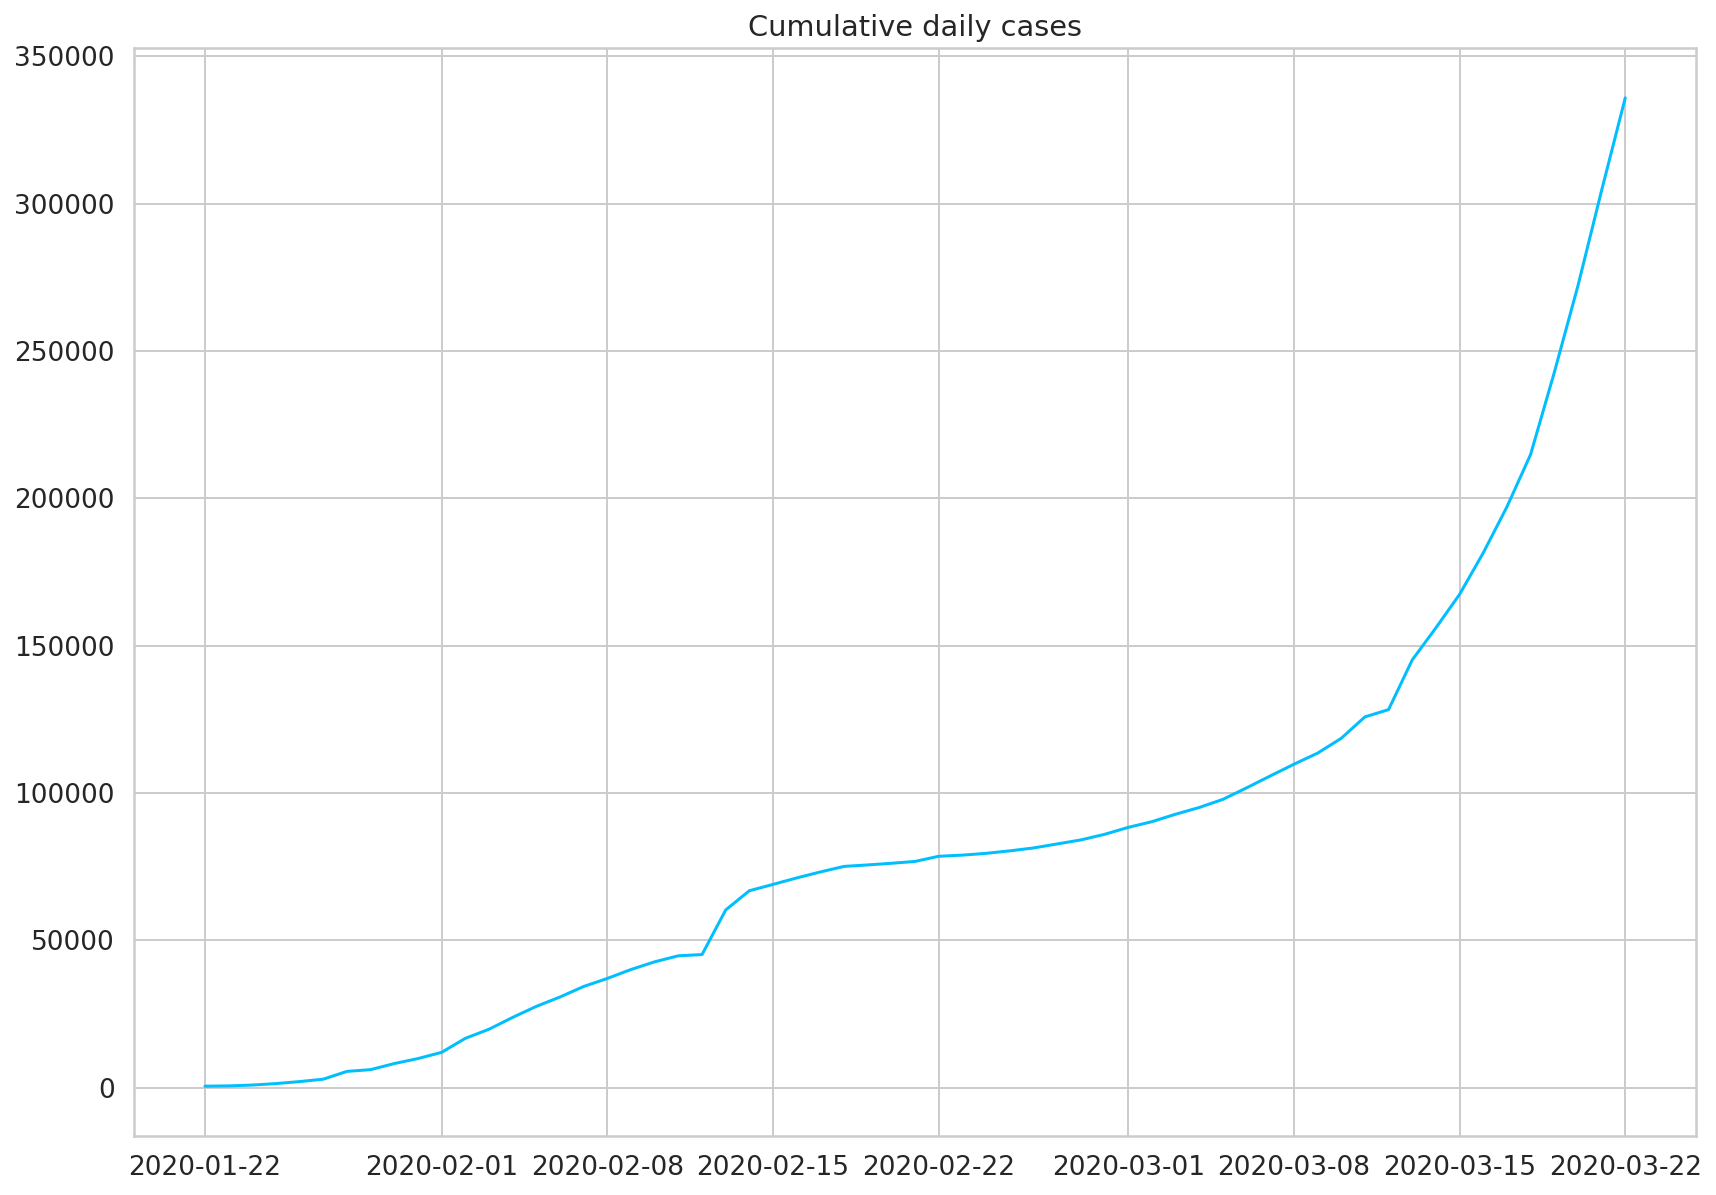

In [11]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

We'll undo the accumulation by subtracting the current value from the previous. We'll preserve the first value of the sequence:

In [12]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

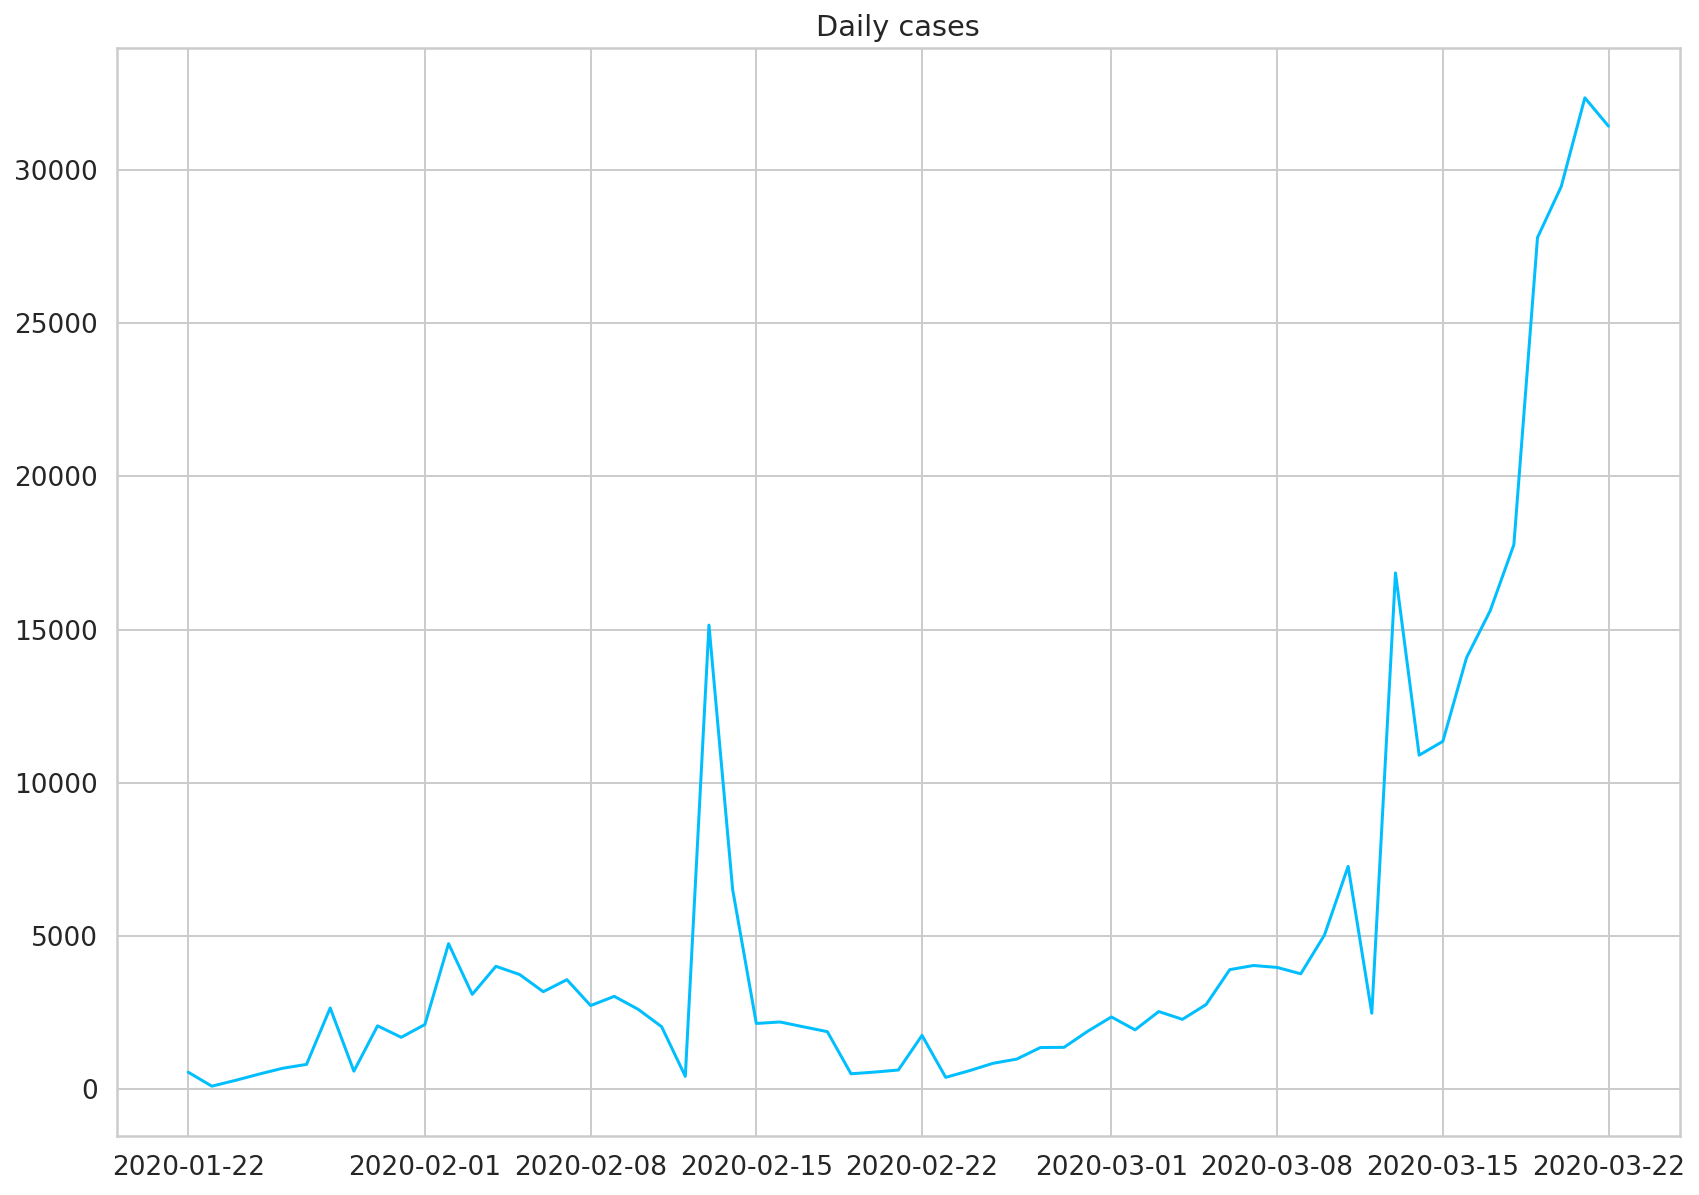

In [13]:
plt.plot(daily_cases)
plt.title("Daily cases");

The huge spike (in the middle) is mostly due to a change of criteria for testing patients in China. This will certainly be a challenge for our model.

Let's check the amount of data we have:

In [14]:
daily_cases.shape

(61,)

Unfortunately, we have data for only 41 days. Let's see what we can do with it!

## Preprocessing

We'll reserve the first 47 days for training and use the rest for testing:

In [15]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(47,)

In [16]:
train_data.head(),train_data.tail()

(2020-01-22    555
 2020-01-23     98
 2020-01-24    288
 2020-01-25    493
 2020-01-26    684
 dtype: int64,
 2020-03-04    2280
 2020-03-05    2762
 2020-03-06    3902
 2020-03-07    4037
 2020-03-08    3974
 dtype: int64)

In [17]:
test_data.head(),test_data.tail()

(2020-03-09     3766
 2020-03-10     5031
 2020-03-11     7273
 2020-03-12     2478
 2020-03-13    16850
 dtype: int64,
 2020-03-18    17768
 2020-03-19    27798
 2020-03-20    29458
 2020-03-21    32358
 2020-03-22    31431
 dtype: int64)

We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model. We'll use the `MinMaxScaler` from scikit-learn:

In [18]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [19]:
# Now the data is not in pd.df but ndarray
len(train_data), train_data[:5], train_data[-5:]

(47,
 array([[0.03036747],
        [0.        ],
        [0.01262542],
        [0.02624759],
        [0.03893946]]),
 array([[0.14499302],
        [0.17702173],
        [0.25277427],
        [0.26174497],
        [0.25755864]]))

In [20]:
len(test_data), test_data[:5], test_data[-5:]

(14,
 array([[0.24373713],
        [0.32779587],
        [0.47677587],
        [0.15815004],
        [1.11316367]]),
 array([[1.1741644 ],
        [1.84065386],
        [1.9509602 ],
        [2.14366403],
        [2.08206525]]))

Currently, we have a big sequence of daily cases. We'll convert it into smaller ones:

In [21]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)] # Take first 5 as X
        y = data[i+seq_length]     # Take the 6th as y
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [22]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let's dive in:

In [23]:
X_train.shape

torch.Size([41, 5, 1])

In [24]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]]])

In [25]:
y_train.shape

torch.Size([41, 1])

In [26]:
y_train[:2]

tensor([[0.0472],
        [0.1696]])

In [27]:
train_data[:10]

array([[0.03036747],
       [0.        ],
       [0.01262542],
       [0.02624759],
       [0.03893946],
       [0.04724566],
       [0.16964582],
       [0.0325603 ],
       [0.13090571],
       [0.10598711]])

## Building a model

We'll wrap our model into a class by extending from `torch.nn.Module`:

In [28]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

Our `CoronaVirusPredictor` contains 3 methods:
- constructor - initialize all helper data and create the layers
- `reset_hidden_state` - we'll use a stateless LSTM, so we need to reset the state after each example
- `forward` - get the sequences, pass all of them through the LSTM layer, at once. We take the output of the last time step and pass it through our linear layer to get the prediction.

## Training

Let's build a helper function for the training of our model (we'll reuse it later):

In [33]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 200

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()

        y_pred = model(X_train)

        loss = loss_fn(y_pred.float(), y_train)

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()

            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    return model.eval(), train_hist, test_hist

We'll use mean squared error to measure our training and test error. We'll record both. Let's create an instance of our model and train it:

In [34]:
model = CoronaVirusPredictor(
  n_features=1, # since we have only one feature of daily confirmed case count
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 2.020188570022583 test loss: 15.957053184509277
Epoch 10 train loss: 1.0514990091323853 test loss: 13.477834701538086
Epoch 20 train loss: 1.0242615938186646 test loss: 13.211847305297852
Epoch 30 train loss: 1.0302636623382568 test loss: 13.180489540100098
Epoch 40 train loss: 1.0289498567581177 test loss: 13.438060760498047
Epoch 50 train loss: 1.0456392765045166 test loss: 13.4674654006958
Epoch 60 train loss: 1.0286674499511719 test loss: 13.905940055847168
Epoch 70 train loss: 1.0437296628952026 test loss: 14.13873291015625
Epoch 80 train loss: 1.0276391506195068 test loss: 14.611534118652344
Epoch 90 train loss: 1.004318118095398 test loss: 15.197530746459961
Epoch 100 train loss: 1.024383783340454 test loss: 16.134244918823242
Epoch 110 train loss: 0.9964480400085449 test loss: 17.245878219604492
Epoch 120 train loss: 0.9977576732635498 test loss: 20.304494857788086
Epoch 130 train loss: 0.9801889657974243 test loss: 20.12594223022461
Epoch 140 train loss: 1.

Let's have a look at the train and test loss:

In [32]:
test_hist

array([15.8802433 , 13.01606274, 10.86640739, 12.12570667, 13.23163795,
       13.8225975 , 14.01280975, 13.99727726, 13.90123653, 13.70870972,
       13.40982819, 13.17597771, 12.93167877, 12.6824131 , 12.52280807,
       12.52383518, 12.58302975, 12.68150234, 12.87273121, 13.02275753,
       13.1733427 , 13.28038597, 13.36721897, 13.41764927, 13.49298096,
       13.51776886, 13.49844265, 13.46296024, 13.40479946, 13.35720921,
       13.27153683, 13.24042225, 13.17544174, 13.14846516, 13.10802174,
       13.17119694, 13.16872597, 13.28775215, 13.2723465 , 13.37926006,
       13.45984554, 13.47856045, 13.57036114, 13.60638714, 13.63529396,
       13.60464764, 13.66622543, 13.66159439, 13.59762764, 13.5859623 ,
       13.55640411, 13.64387512, 13.63704967, 13.6057663 , 13.66128635,
       13.67239952, 13.76229668, 13.80153465, 13.85069656, 13.91545582])

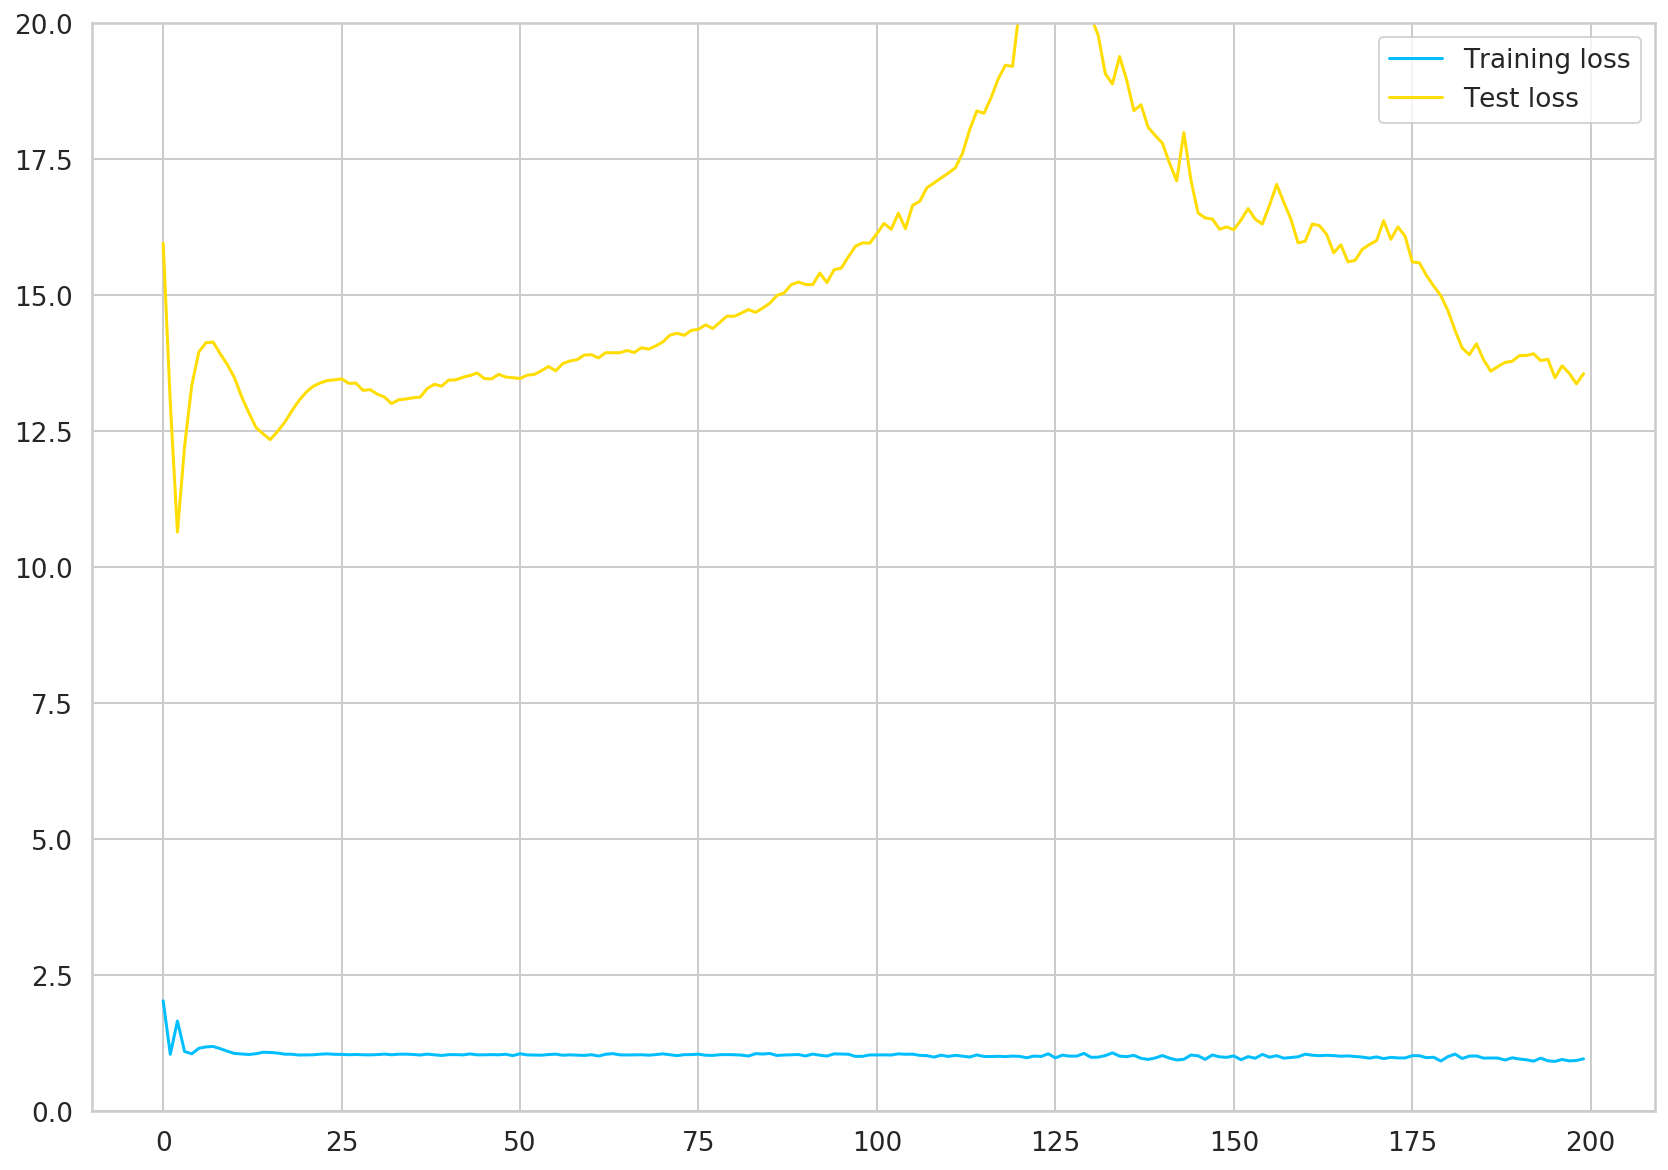

In [35]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 20))
plt.legend();

Our model's performance doesn't improve after 15 epochs or so. Recall that we have very little data, our model shouldn't be trusted.

## Predicting daily cases

Our model can (due to the way we've trained it) predict only a single day in the future. We'll employ a simple strategy to overcome this limitation. Use predicted values as input for predicting the next days:

In [36]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        # add the newly predicted value
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

We have to reverse the scaling of the test data and the model predictions:

In [37]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Let's look at the results:

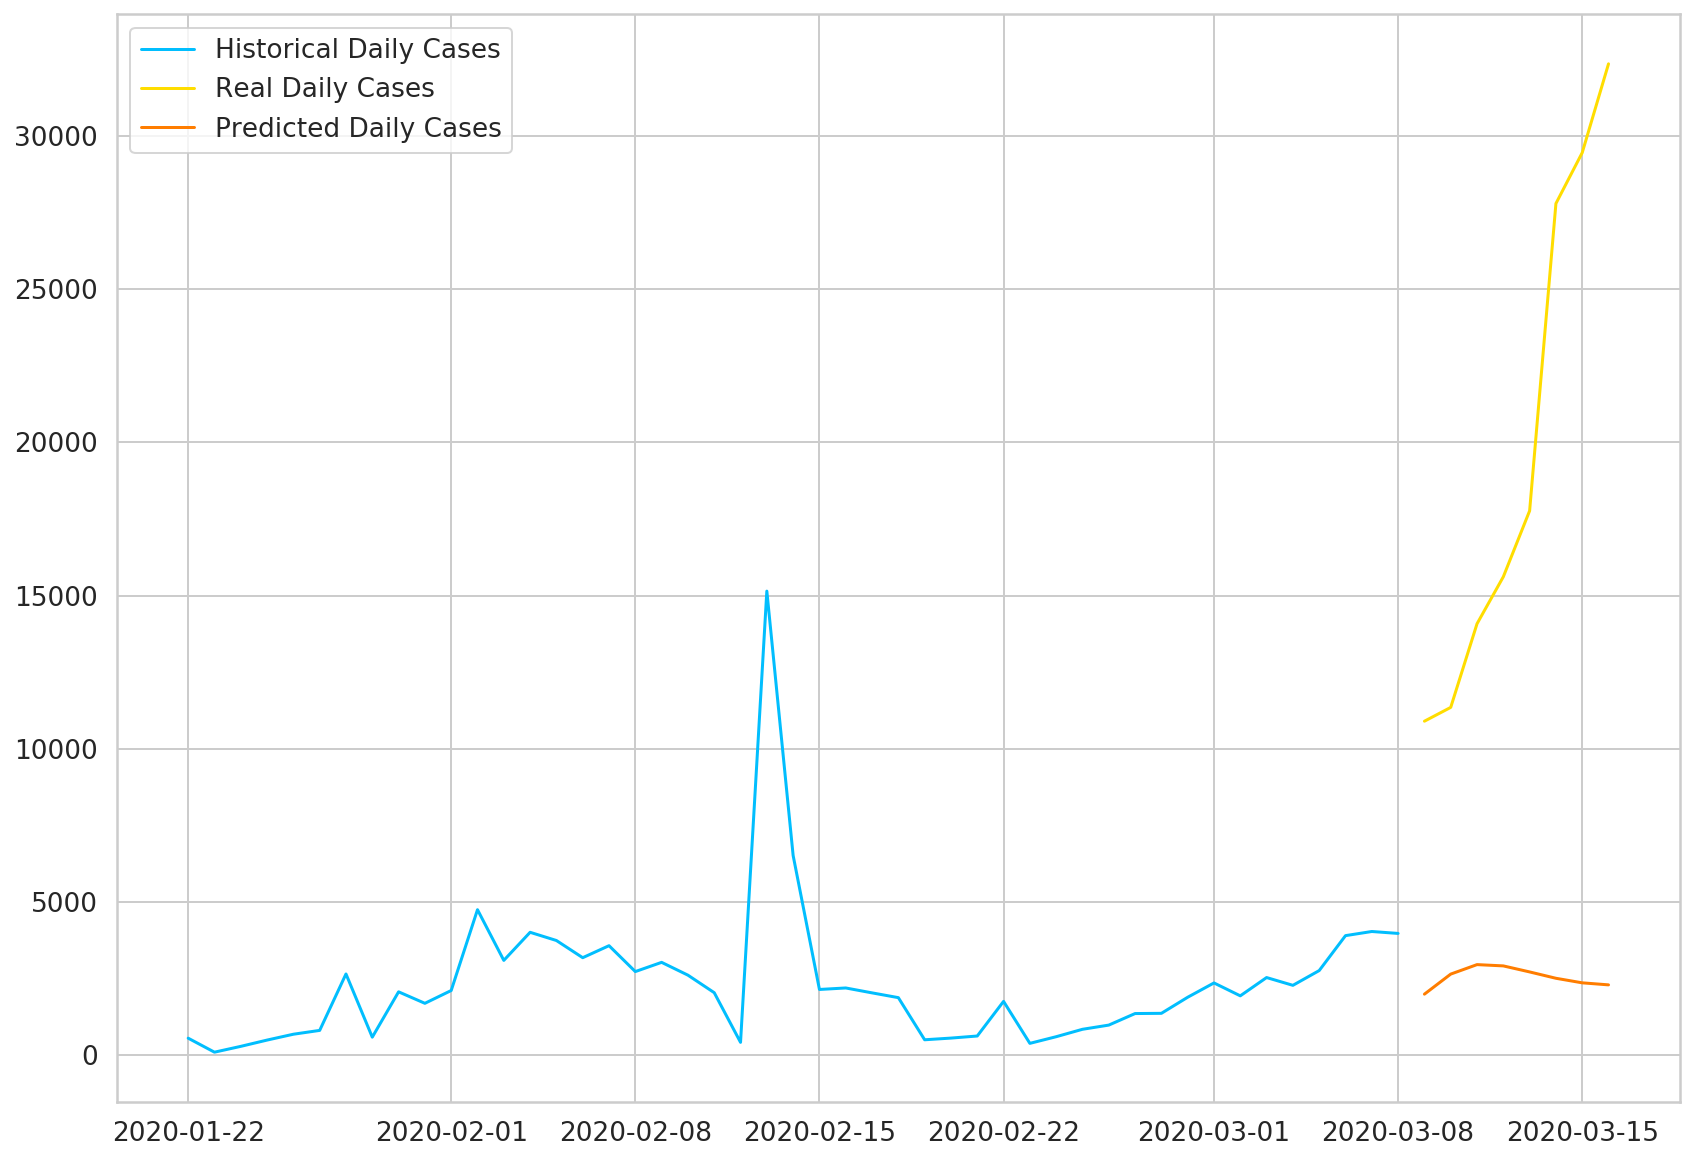

In [38]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

As expected, our model doesn't perform very well. That said, the predictions seem to be in the right ballpark (probably due to using the last data point as a strong predictor for the next).

## Use all data for training

In [39]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(61, 1)

In [40]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

In [41]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.712217926979065
Epoch 10 train loss: 1.0320085287094116
Epoch 20 train loss: 1.0418494939804077
Epoch 30 train loss: 1.0329941511154175
Epoch 40 train loss: 1.0421990156173706
Epoch 50 train loss: 1.0217334032058716
Epoch 60 train loss: 1.0160553455352783
Epoch 70 train loss: 1.0462173223495483
Epoch 80 train loss: 0.990342915058136
Epoch 90 train loss: 0.9841727614402771
Epoch 100 train loss: 1.0328714847564697
Epoch 110 train loss: 1.0382663011550903
Epoch 120 train loss: 1.0006000995635986
Epoch 130 train loss: 0.9772948622703552
Epoch 140 train loss: 0.9980682730674744
Epoch 150 train loss: 1.0190610885620117
Epoch 160 train loss: 0.9953158497810364
Epoch 170 train loss: 0.9557390213012695
Epoch 180 train loss: 0.9981091618537903
Epoch 190 train loss: 0.9363442659378052


## Predicting future cases

In [42]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [43]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [44]:
daily_cases.index[-1]

Timestamp('2020-03-22 00:00:00')

In [45]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

In [46]:
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

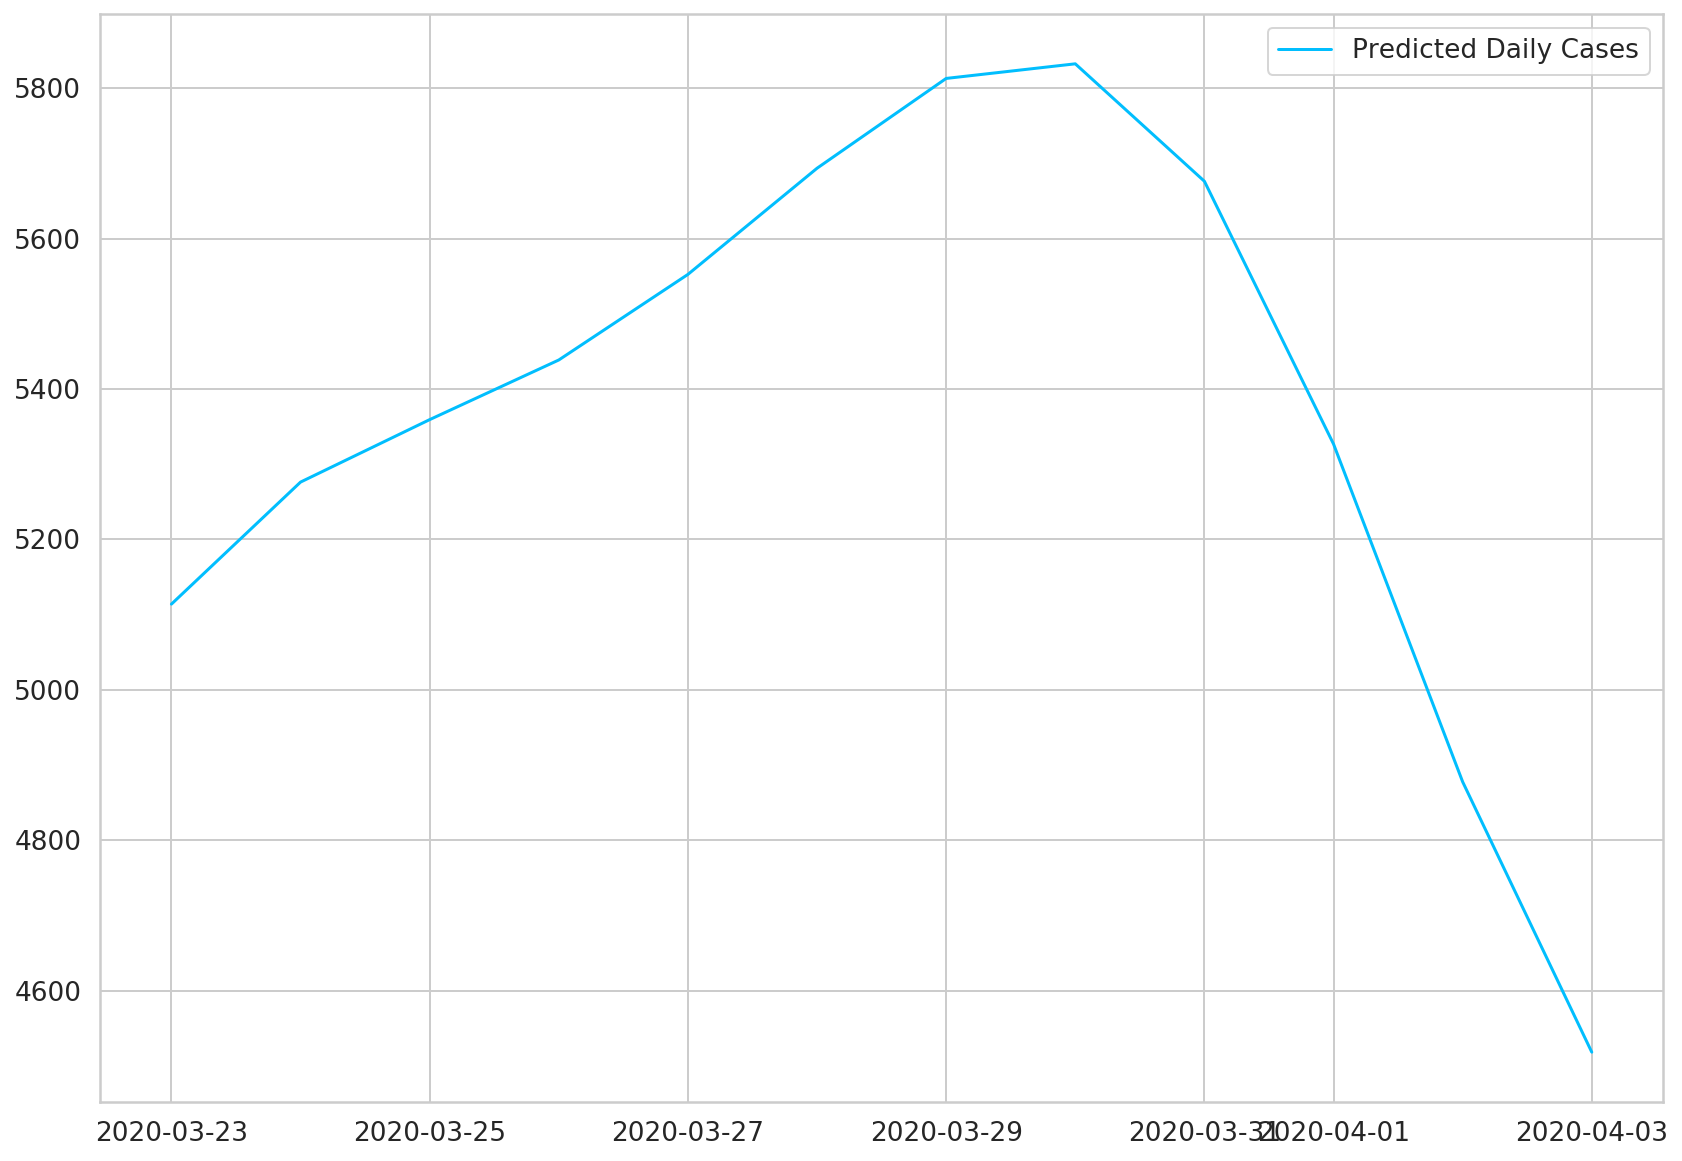

In [47]:
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

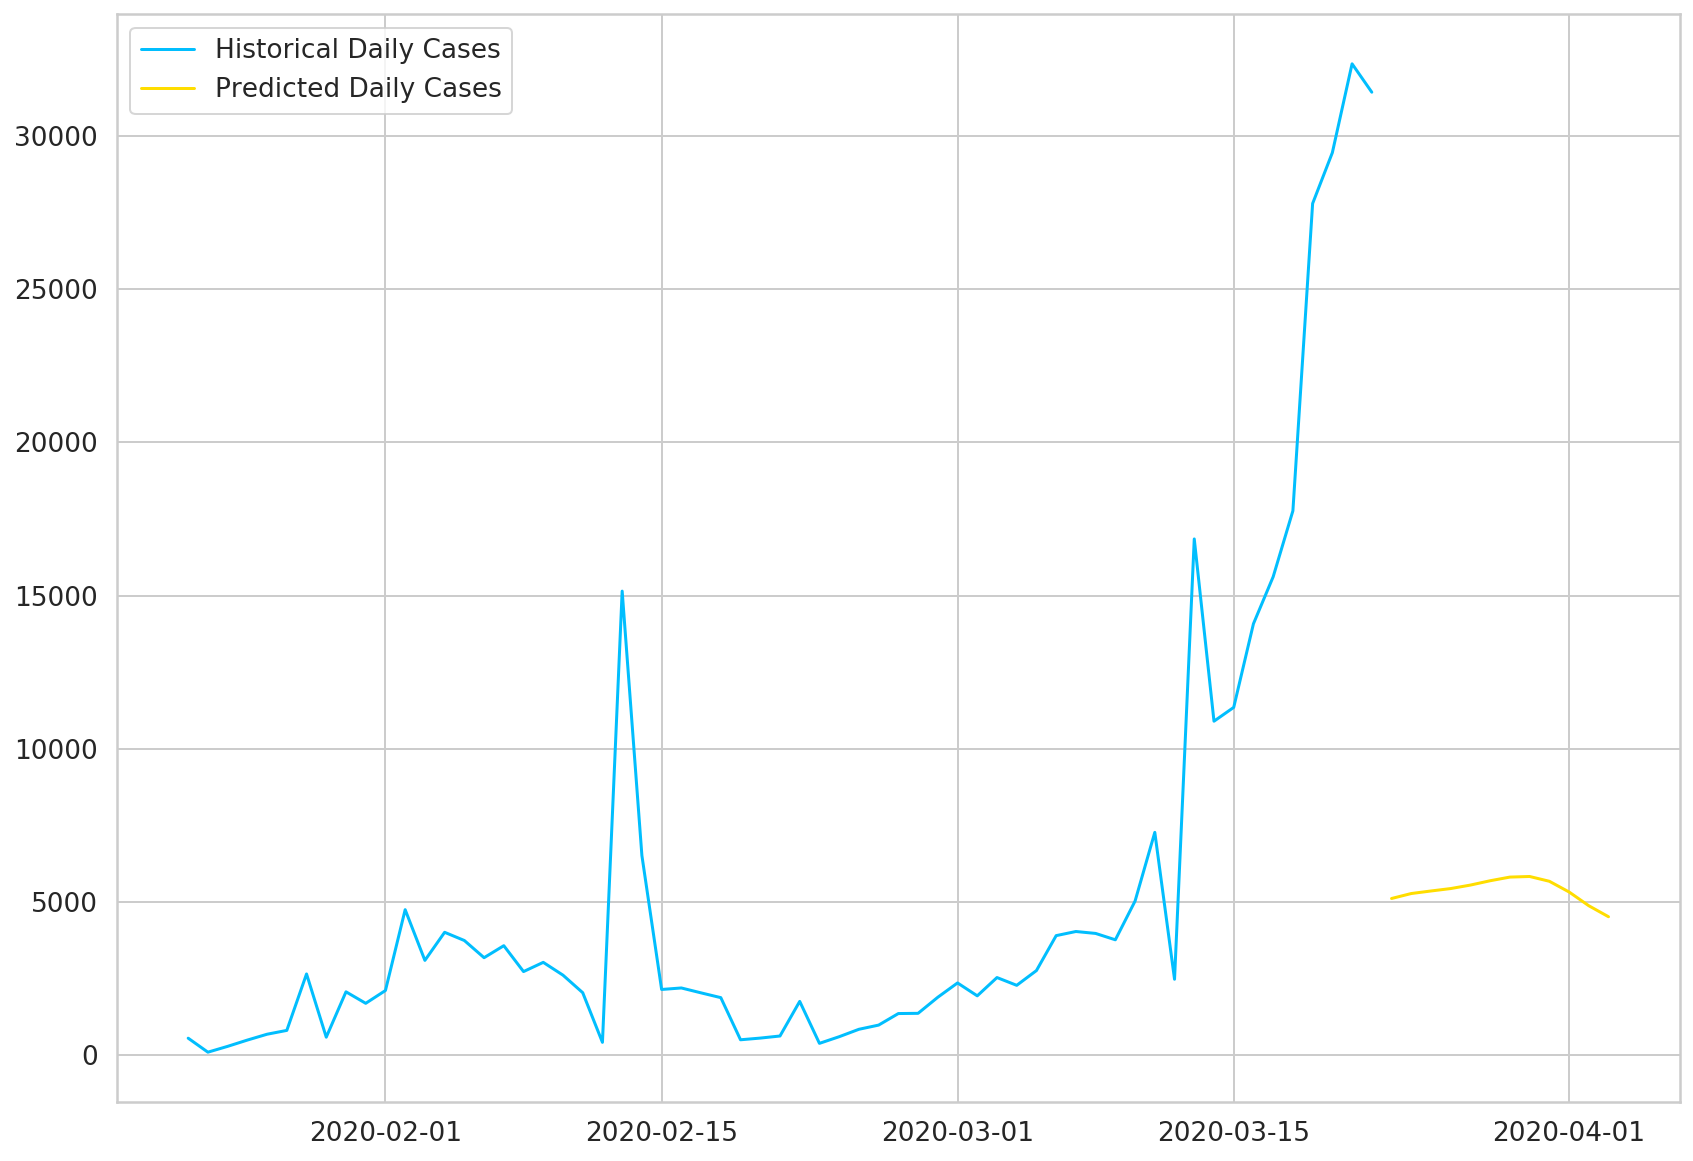

In [48]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

## References

- [Sequence Models PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [LSTM for time series prediction](https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca)
- [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Stateful LSTM in Keras](https://philipperemy.github.io/keras-stateful-lstm/)
- [LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/)
- [Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE](https://github.com/CSSEGISandData/COVID-19)
- [covid-19-analysis](https://github.com/AaronWard/covid-19-analysis)
- [How does Coronavirus compare to Ebola, SARS, etc?](https://www.youtube.com/watch?v=6dDD2tHWWnU)
- [Worldometer COVID-19 Coronavirus Outbreak](https://www.worldometers.info/coronavirus/)
- [How contagious is the Wuhan Coronavirus? (Ro)](https://www.worldometers.info/coronavirus/#repro)
- [Systemic Risk of Pandemic via Novel Pathogens - Coronavirus: A Note](https://www.academia.edu/41743064/Systemic_Risk_of_Pandemic_via_Novel_Pathogens_-_Coronavirus_A_Note)
- [Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications](https://www.researchers.one/article/2020-01-21)
